# 参数更新

神经网络的学习的目的是为了找到最优参数，使得损失函数的值尽可能小。这个过程称为最优化（optimization）。

为了找到最优参数，我们需要计算参数的梯度（导数）。梯度表示损失函数的值减小最多的方向。因此，沿着梯度方向更新参数，重复这个步骤，就可以逐渐减小损失函数的值。这个方法称为随机梯度下降法（stochastic gradient descent，SGD）。随机梯度下降法是深度学习中最优化的方法。

## SGD

可以将SGD写成如下的数学公式
$$
W \leftarrow W - \eta \frac {\partial L} {\partial W}
$$

这里把需要更新的权重参数记为$W$, 把损失函数关于$W$的梯度记为$\frac {\partial L} {\partial W}$, $\eta$表示为学习率，实际上会取0.01或者0.001这样事先取好的值。我们将其实现为一个名为SGD的Pythong类。

In [ ]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr # learning rate

    def update(self, params, grads):
        # 参数 params 和 grads 是字典型变量，按 params['W1'] 、grads['W1'] 的形式，分别保存了权重参数和它们对应的梯度。
        for key in params.keys():
            params[key] -= self.lr * grads[key]

# 使用方式
# network = TwoLayerNet(...)
# optimizer = SGD()

# for i in range(10000):
#     ...
#     x_batch, t_batch = get_mini_batch(...) # mini-batch
#     grads = network.gradient(x_batch, t_batch)
#     params = network.params
#     optimizer.update(params, grads)
#     ...

这里首次出现的变量名optimizer表示“进行最优化的人”的意思，这里由 SGD 承担这个角色。参数的更新由 optimizer 负责完成。我们在这里需要做的只是将参数和梯度的信息传给 optimizer 。

SGD 的缺点是，如果函数的形状非均向（anisotropic），比如呈延伸状，搜索的路径就会非常低效。因此，我们需要比单纯朝梯度方向前进的 SGD 更聪明的方法。SGD 低效的根本原因是，梯度的方向并没有指向最小值的方向。为了改正SGD的缺点，引入了**Momentum**、AdaGrad、Adam这 3 种方法来取代SGD。

![SGD](https://www.acceluniverse.com/blog/developers/72fd50b9f062584b903409340b434584013608a7.png)

## Momentum

Monmentum方法的数学表示如下：
$$
\begin{aligned}
v &\leftarrow \alpha v - \eta \frac {\partial L} {\partial W} \\
W &\leftarrow W + v
\end{aligned}
$$

这里的变量$v$，对应物理上的速度，表示物体在梯度方向上受力，在这个力的作用下，物体的速度增加这一物理法则。$\alpha$是摩擦力或空气阻力，表示在不受力时，物体逐渐减速的物理现象。Momentum 方法给人的感觉就像是小球在地面上滚动。


In [ ]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr # 学习率
        self.momentum = momentum # 动量
        self.v = None # 速度

    def update(self, params, grads):
        # 参数 params 和 grads 是字典型变量，按 params['W1'] 、grads['W1'] 的形式，分别保存了权重参数和它们对应的梯度。
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val) # 初始化速度 v

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] # 更新速度 v
            params[key] += self.v[key] # 更新参数

动量法几乎总是比标准的梯度下降法速度更快，算法的主要思想是计算梯度的指数加权平均，然后使用这个梯度来更新权重。可以理解为，在到达新的一点时，SGD会直接按照该点的负梯度方向去更新，而Momentum会考虑之前的梯度及方向，即动量。更新的时候考虑梯度均值（指数加权平均），指数衰减理解为摩擦力造成的损失。

![Momentum](https://www.acceluniverse.com/blog/developers/75292d88e0b6da3cb7c1d89da3416387be2998e9.png)

## AdaGrad

在神经网络的学习中，学习率（数学式中记为$\eta$ ）的值很重要。学习率过小，会导致学习花费过多时间；反过来，学习率过大，则会导致学习发散而不能正确进行。

在关于学习率的有效技巧中，有一种被称为学习率衰减（learning rate decay）的方法，即随着学习的进行，使学习率逐渐减小。即，一开始“多”学，然后逐渐“少”学。（学习的意思是朝着损失函数最低处进行优化）。

逐渐减小学习率的想法，相当于将“全体”参数的学习率值一起降低。而 AdaGrad进一步发展了这个想法，针对“一个一个”的参数，赋予其“定制”的值。

AdaGrad 会为参数的每个元素适当地调整学习率，与此同时进行学习（AdaGrad 的 Ada 来自英文单词 Adaptive，即“适当的”的意思）。逐渐减小学习率的想法，相当于将“全体”参数的学习率值一起降低。下面，让我们用数学式表示 AdaGrad 的更新方法。

$$
\begin{aligned}
h &\leftarrow h + \frac {\partial L} {\partial W} \odot \frac {\partial L} {\partial W} \\
W &\leftarrow W - \eta \frac 1 {\sqrt h} \frac {\partial L} {\partial W}
\end{aligned}
$$

这里新出现了变量 $h$，它保存了以前的所有梯度值的平方和($\odot$表示对应矩阵元素的乘法)。然后，在更新参数时，通过乘以$\frac 1 {\sqrt h}$，就可以调整学习的尺度。这意味着，参数的元素中变动较大（被大幅更新）的元素的学习率将变小。也就是说，可以按参数的元素进行学习率衰减，使变动大的参数的学习率逐渐减小。

> AdaGrad 会记录过去所有梯度的平方和。因此，学习越深入，更新的幅度就越小。实际上，如果无止境地学习，更新量就会变为 0，完全不再更新。为了改善这个问题，可以使用 RMSProp 方法。RMSProp 方法并不是将过去所有的梯度一视同仁地相加，而是逐渐地遗忘过去的梯度，在做加法运算时将新梯度的信息更多地反映出来。这种操作从专业上讲，称为“指数移动平均”，呈指数函数式地减小过去的梯度的尺度。

In [ ]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr # 学习率
        self.h = None # h

    def update(self, params, grads):
        # 参数 params 和 grads 是字典型变量，按 params['W1'] 、grads['W1'] 的形式，分别保存了权重参数和它们对应的梯度。
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val) # 初始化 h

        for key in params.keys():
            self.h[key] += grads[key] * grads[key] # 更新 h
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 更新参数

![AdaGrad](https://www.acceluniverse.com/blog/developers/b1b69a05722e3901b97d6e9618e157cd3e29fbca.png)

函数的取值高效地向着最小值移动。由于 y 轴方向上的梯度较大，因此刚开始变动较大，但是后面会根据这个较大的变动按比例进行调整，减小更新的步伐。因此，y 轴方向上的更新程度被减弱，“之”字形的变动程度有所衰减。

## Adam

Momentum参照小球在碗中滚动的物理规则进行移动，AdaGrad为参数的每个元素适当地调整更新步伐。如果将这两个方法融合在一起会怎样呢？这就是Adam方法的基本思路。

Adam 是在2015年被提出的新方法，从直觉上看，就像是 Momentum 和 AdaGrad 的融合。将这两种方法的优点结合起来，就可以期待有效地探索参数空间。另外，对超参数进行“偏置校正”也是 Adam 的特征。

In [ ]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr # 学习率
        self.beta1 = beta1 # beta1
        self.beta2 = beta2 # beta2
        self.iter = 0 # 迭代次数
        self.m = None # m
        self.v = None # v

    def update(self, params, grads):
        # 参数 params 和 grads 是字典型变量，按 params['W1'] 、grads['W1'] 的形式，分别保存了权重参数和它们对应的梯度。
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val) # 初始化 m
                self.v[key] = np.zeros_like(val) # 初始化 v

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter) # 学习率衰减

        for key in params.keys():
            # 更新 m 和 v
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            # 更新参数
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

![Adam](https://www.acceluniverse.com/blog/developers/3167008140b39cf6d554a1682662ac132d7cc1cc.png)

基于Adam的更新过程就像小球在碗中滚动一样。虽然Monmentum也有类似的运动，但是相比之下，Adam的小球左右摇晃的程度有所减轻。这得益于学习率的更新程度被适当地调整了。

# 权重的初始值

在神经网络的学习中，权重的初始值特别重要。设定什么样的权重初始值，经常关系到神经网络的学习能否成功。

将权重初始值设为0的话，将无法正确进行学习。为什么不能将权重初始值设成一样的值呢？这是因为在误差反向传播法中，所有的权重值都会进行相同的更新。这使得神经网络拥有许多不同的权重的意义丧失了。为了防止“权重均一化”（严格地讲，是为了瓦解权重的对称结构），必须随机生成初始值。

反向传播中梯度的值不断变小，最后消失。这个问题称为梯度消失（gradient vanishing）。层次加深的深度学习中，梯度消失的问题可能会更加严重。

权重初始值的优化有三个要点（结论）：
1. 权重初始值必须是随机生成的。
2. 当激活函数使用sigmoid或tanh函数(正切函数)等 S 型曲线函数时，初始值使用Xavier初始值。
3. 当激活函数使用ReLU时，权重初始值使用He初始值。

> 为什么要随机生成权重初始值呢？
> 在误差反向传播法中，所有的权重值都会进行 相同的更新。比如，在2层神经网络中，假设第1层和第2层的权重为0。这 样一来，正向传播时，因为输入层的权重为0，所以第2层的神经元全部会 被传递相同的值。第2层的神经元中全部输入相同的值，这意味着反向传播 时第2层的权重全部都会进行相同的更新（回忆一下“乘法节点的反向传播” ）。因此，权重被更新为相同的值，并拥有了对称的值（重复的值）。 这使得神经网络拥有许多不同的权重的意义丧失了。为了防止“权重均一化” （严格地讲，是为了瓦解权重的对称结构），必须随机生成初始值。

各层的激活值的分布都要求有适当的广度（分布均匀），因为在各层之间传递多样性的数据，神经网络就可以进行高效地学习。反过来，如果传递的都是有所偏向的数据（分布不均匀），就会出现梯度消失或者 “表现力受限” 的问题，导致学习可能无法顺利进行。

## 隐藏层的激活值的分布

这里，我们来做一个简单的实验，观察权重初始值是如何影响隐藏层的 激活值的分布的。这里要做的实验是，向一个5层神经网络（激活函数使用 sigmoid函数）传入随机生成的输入数据，用直方图绘制各层激活值的数据分布。

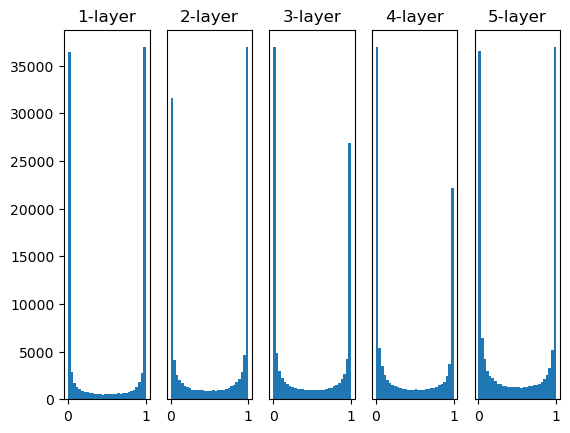

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def draw_histogram(func):
    x = np.random.randn(1000, 100) # 1000 个数据
    node_num = 100 # 各隐藏层的节点（神经元）数
    hidden_layer_size = 5 # 隐藏层有 5 层
    activations = {} # 激活值的结果保存在这里

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        # w = np.random.randn(node_num, node_num) * 1 # 权重的标准差设为 1
        # w = np.random.randn(node_num, node_num) * 0.01 # 权重的标准差设为 0.01
        w = func(node_num) #np.random.randn(node_num, node_num) / np.sqrt(node_num) # Xavier 初始值
        # w = np.random.randn(node_num, node_num) / np.sqrt(node_num / 2) # He 初始值

        a = np.dot(x, w)

        # 将激活函数的种类也改变试验一下
        z = sigmoid(a)
        # z = np.maximum(a, 0) # ReLU

        activations[i] = z

    # 绘制直方图
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        plt.hist(a.flatten(), 30, range=(0,1))
    plt.show()

draw_histogram(lambda node_num: np.random.randn(node_num, node_num) * 1) # 权重的标准差设为 1

各层的激活值呈偏向0和1的分布。这里使用的sigmoid 函数是S型函数，随着输出不断地靠近0（或者靠近1），它的导数的值逐渐接 近0。因此，偏向0和1的数据分布会造成反向传播中梯度的值不断变小，最 后消失。这个问题称为梯度消失（gradient vanishing）。层次加深的深度学习 中，梯度消失的问题可能会更加严重。

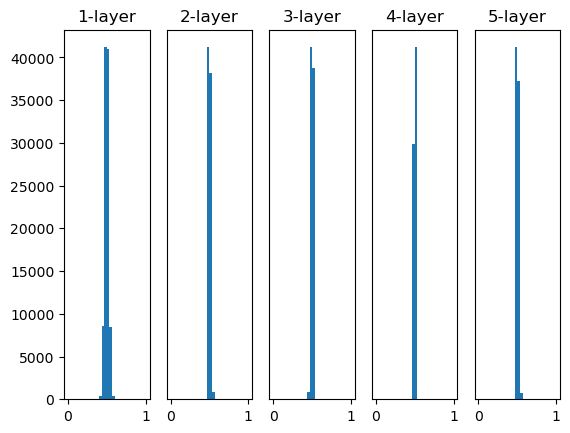

In [12]:
draw_histogram(lambda node_num: np.random.randn(node_num, node_num) * 0.01) # 权重的标准差设为 0.01

这次呈集中在0.5附近的分布。因为不像刚才的例子那样偏向0和1，所 以不会发生梯度消失的问题。但是，激活值的分布有所偏向，说明在表现力 上会有很大问题。为什么这么说呢？因为如果有多个神经元都输出几乎相同 的值，那它们就没有存在的意义了。比如，如果100个神经元都输出几乎相 同的值，那么也可以由1个神经元来表达基本相同的事情。因此，激活值在 分布上有所偏向会出现“表现力受限”的问题。

各层的激活值的分布都要求有适当的广度。为什么呢？因为通过 在各层间传递多样性的数据，神经网络可以进行高效的学习。反 过来，如果传递的是有所偏向的数据，就会出现梯度消失或者“表现力受限”的问题，导致学习可能无法顺利进行。

Xavier的论文中，为了使各层的激活值呈现出具有相同广度的分布，推导了合适的权重尺度。推导出的结论是，如果前一层的节点数为n，初始值使用标准差为$\frac 1 {\sqrt n}$。

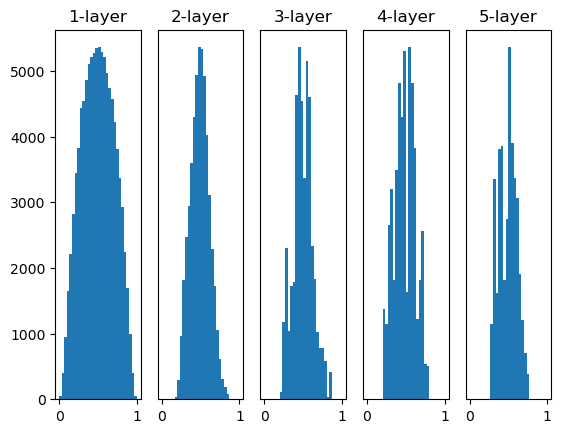

In [13]:
draw_histogram(lambda node_num: np.random.randn(node_num, node_num) / np.sqrt(node_num)) # Xavier 初始值

从这个结果可知，越是后 面的层，图像变得越歪斜，但是呈现了比之前更有广度的分布。因为各层间 传递的数据有适当的广度，所以sigmoid函数的表现力不受限制，有望进行 高效的学习

后面的层的分布呈稍微歪斜的形状。如果用tanh 函数（双曲线函数）代替sigmoid函数，这个稍微歪斜的问题就能得 到改善。实际上，使用tanh函数后，会呈漂亮的吊钟型分布。tanh 函数和sigmoid函数同是 S型曲线函数，但tanh函数是关于原点(0, 0) 对称的 S型曲线，而sigmoid函数是关于(x, y)=(0, 0.5)对称的S型曲 线。众所周知，用作激活函数的函数最好具有关于原点对称的性质。

但当激活函数使用ReLU时，一般推荐使用ReLU专 用的初始值，也就是Kaiming He等人推荐的初始值，也称为“He初始值”。初始值为$\sqrt {\frac n 2}$。

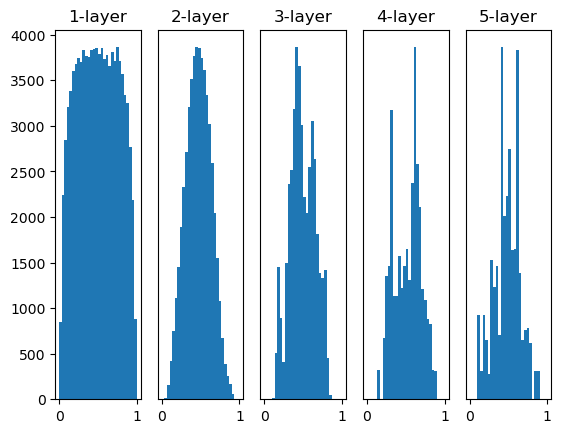

In [14]:
draw_histogram(lambda node_num: np.random.randn(node_num, node_num) / np.sqrt(node_num / 2)) # He 初始值

In [ ]:
# 随机初始值
w = 0.01 * np.random.randn(10, 100)  # 标准差为0.01 的高斯分布

# Xavier 初始值
w = np.random.randn(n) / np.sqrt(n) # 标准差为 1/sqrt(n) 的高斯分布

# He 初始值
w = np.random.randn(n) / np.sqrt(n/2) # 标准差为 sqrt(2/n) 的高斯分布

> 如果不知道使用什么权重初始值，那就使用He初始值；Adam方法带来的影响大于初始值带来的影响。

# Batch Normalization

Batch Norm的思路是调整各层的激活值分布使其拥有适当的广度。为此，要向神经网络中插入对数据分布进行正规化的层，即BatchNormalization层（下文简称Batch Norm层）。

![BatchNorm](img/batchnorm.png)

Batch Norm有以下优点：
- 可以使学习快速进行（可以增大学习率）。
- 不那么依赖初始值（对于初始值不用那么敏感）。
- 抑制过拟合（降低Dropout等的必要性）。

考虑到深度学习要花费很多时间，第一个优点令人非常开心。另外，后两点也可以帮我们消除深度学习的学习中的很多烦恼。

Batch Norm，顾名思义，以进行学习时的 mini-batch 为单位，按 mini-batch 进行正规化。具体而言，就是进行使数据分布的均值为 0、方差为 1 的正规化。用数学式表示的话，如下所示。
$$
\begin{aligned}
\mu_B &\leftarrow \frac 1 m \sum_{i=1}^m x_i \\
\sigma^2_B &\leftarrow \frac 1 m \sum_{i=1}^m(x_i - \mu_B)^2 \\
\hat x_i &\leftarrow \frac {x_i - \mu_B} {\sqrt {\sigma^2_B + \epsilon}}
\end{aligned}
$$

这里对mini-batch的m个输入数据的集合B求均值$\mu_B$和方差$\sigma_B^2$，然后对mini-batch的输入数据$\{x_1, x_2, ... ,x_m \}$变换为均值为0、方差为1的数据$\{\hat x_1, \hat x_2, ..., \hat x_m\}$ ，非常简单。通过将这个处理插入到激活函数的前面（或者后面），可以减小数据分布的偏向。

接着，Batch Norm层会对正规化后的数据进行缩放和平移的变换，用数学式可以如下表示。
$$
y_i \leftarrow \gamma \hat x_i + \beta
$$

这里，$\gamma$和$\beta$是参数。一开始$\gamma = 1, \beta = 0$，然后再通过学习调整到合适的值。上面就是Batch Norm的算法。这个算法是神经网络上的正向传播。BatchNorm可以表示为如下的计算图。

![BatchNorm](img/batchnorm2.avif)

使用MNIST数据集，观察使用Batch Norm层和不使用Batch Norm层，以及给予不同的初始值尺度，观察学习的过程如何变化。

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

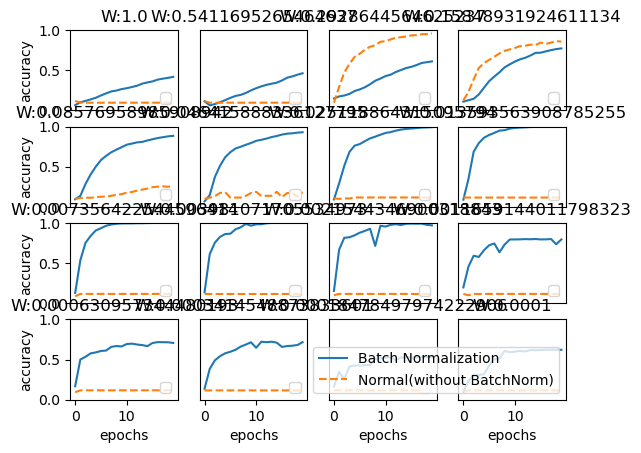

In [22]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            #print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list

weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    # print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()


我们发现几乎所有的情况下都是使用Batch Norm时学习进行得更快。同时也可以发现，实际上，在不使用Batch Norm的情况下，如果不赋予一个尺度好的初始值，学习将完全无法进行。

通过使用Batch Norm，可以推动学习的进行。并且，对权重初始值变得健壮（“对初始值健壮”表示不那么依赖初始值）。

# 正则化

## 过拟合
机器学习的问题中，过拟合是一个很常见的问题。过拟合指的是只能拟合训练数据，但不能很好地拟合不包含在训练数据中的其他数据的状态。机器学习的目标是提高泛化能力，即便是没有包含在训练数据里的未观测数据， 也希望模型可以进行正确的识别。

发生过拟合的原因，主要有以下两个。
1. 模型拥有大量参数、表现力强。
2. 训练数据少。

这里，我们故意满足这两个条件，制造过拟合现象。为此，要从MNIST数据集原本的60000个训练数据中只选定300个，并且，为了增加网络的复杂度，使用7层网络（每层有100个神经元，激活函数为ReLU）。其结果如下所示。

![Overfit](img/overfit.webp)

过了 100 个 epoch 左右后，用训练数据测量到的识别精度几乎都为100%。但是，对于测试数据，离100%的识别精度还有较大的差距。如此大的识别精度差距，是只拟合了训练数据的结果。从图中可知，模型对训练时没有使用的一般数据（测试数据）拟合得不是很好。

## 权值衰减

权值衰减是一直以来经常被使用的一种抑制过拟合的方法。该方法通过在学习的过程中对大的权重进行惩罚，来抑制过拟合。很多过拟合原本就是因为权重参数取值过大才发生的。

复习一下，神经网络的学习目的是减小损失函数的值。这时，例如为损失函数加上权重的平方范数（$L2$范数）。这样一来，就可以抑制权重变大。用符号表示的话，如果将权重记为$W$，$L2$范数的权值衰减就是$\frac 1 2 \lambda W^2$，然后将这个$\frac 1 2 \lambda W^2$加到损失函数上。这里，$\lambda$是控制正则化强度的超参数。$\lambda$设置得越大，对大的权重施加的惩罚就越重。此外，$\frac 1 2 \lambda W^2$开头$\frac 1 2$的是用于将$\frac 1 2 \lambda W^2$的求导结果变成$\lambda W$的调整用常量。

对于所有权重，权值衰减方法都会为损失函数加上$\frac 1 2 \lambda W^2$。因此，在求权重梯度的计算中，要为之前的误差反向传播法的结果加上正则化项的导数$\lambda W$。

> L2范数相当于各个元素的平方和，即$L2=\sqrt {w_1^2+w_2^2+...+w_n^2}$。

现在我们来进行实验。对于刚刚进行的实验，应用$\lambda = 0.1$的权值衰减，结果如下所示。

epoch:0, train acc:0.06666666666666667, test acc:0.0893
epoch:1, train acc:0.08, test acc:0.0919
epoch:2, train acc:0.09666666666666666, test acc:0.0975
epoch:3, train acc:0.12666666666666668, test acc:0.1043
epoch:4, train acc:0.15666666666666668, test acc:0.1107
epoch:5, train acc:0.19666666666666666, test acc:0.1239
epoch:6, train acc:0.22666666666666666, test acc:0.1338
epoch:7, train acc:0.23, test acc:0.1463
epoch:8, train acc:0.25333333333333335, test acc:0.1496
epoch:9, train acc:0.28, test acc:0.1592
epoch:10, train acc:0.31333333333333335, test acc:0.1679
epoch:11, train acc:0.3433333333333333, test acc:0.1845
epoch:12, train acc:0.34, test acc:0.1944
epoch:13, train acc:0.36333333333333334, test acc:0.2019
epoch:14, train acc:0.3933333333333333, test acc:0.2155
epoch:15, train acc:0.39666666666666667, test acc:0.2272
epoch:16, train acc:0.42333333333333334, test acc:0.2415
epoch:17, train acc:0.46, test acc:0.2626
epoch:18, train acc:0.47, test acc:0.2682
epoch:19, train acc

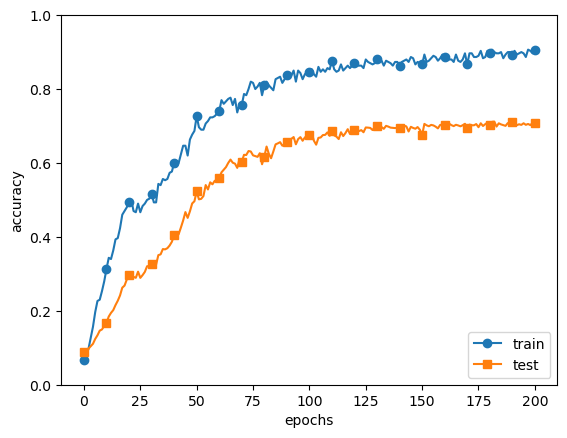

In [23]:
import os
import sys

sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（权值衰减）的设定 =======================
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        # print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

如上图所示，虽然训练数据的识别精度和测试数据的识别精度之间有差距，但是与没有使用权值衰减的的结果相比，差距变小了。这说明过拟合受到了抑制。此外，还要注意，训练数据的识别精度没有达到100%。

## Dropout

权值衰减方法可以简单地实现，在某种程度上能够抑制过拟合。但是，如果网络的模型变得很复杂，只用权值衰减就难以应对了。在这种情况下，我们经常会使用Dropout方法。

Dropout是一种在学习的过程中随机删除神经元的方法。训练时，随机选出隐藏层的神经元，然后将其删除。被删除的神经元不再进行信号的传递。训练时，每传递一次数据，就会随机选择要删除的神经元。然后，测试时，虽然会传递所有的神经元信号，但是对于各个神经元的输出， 要乘上训练时的删除比例后再输出。其结构如下图所示。

![Dropout](img/dropout.webp)

下面我们来实现Dropout。这里的实现重视易理解性。不过，因为训练时如果进行恰当的计算的话，正向传播时单纯地传递数据就可以了（不用乘以删除比例），所以深度学习的框架中进行了这样的实现。

In [ ]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio # 丢弃率

    def forward(self, x, train_flg=True):
        if train_flg:
            # 训练阶段
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio # 生成与 x 形状相同的 True / False 数组
            return x * self.mask # 对 x 中的元素进行掩码处理
        else:
            # 推理阶段
            return x * (1.0 - self.dropout_ratio) # 乘以比例

    def backward(self, dout):
        return dout * self.mask # 反向传播时，将正向传播时的掩码位置设为 0

这里的要点是，每次正向传播时，self.mask中都会以False的形式保存要删除的神经元。self.mask会随机生成和x形状相同的数组，并将值比dropout_ratio大的元素设为True。反向传播时的行为和ReLU相同。也就是说， 正向传播时传递了信号的神经元，反向传播时按原样传递信号；正向传播时没有传递信号的神经元，反向传播时信号将停在那里。

现在，我们使用MNIST数据集进行验证，以确认Dropout的效果。其结果如下图所示。

train loss:2.3251234059536574
=== epoch:1, train acc:0.12666666666666668, test acc:0.1014 ===
train loss:2.327166563967514
train loss:2.295713490201493
train loss:2.3084444158561976
=== epoch:2, train acc:0.12666666666666668, test acc:0.105 ===
train loss:2.3166100210106775
train loss:2.2883168316050386
train loss:2.3194335505459764
=== epoch:3, train acc:0.13666666666666666, test acc:0.1069 ===
train loss:2.3009097898126294
train loss:2.297685202641848
train loss:2.293395031484062
=== epoch:4, train acc:0.14333333333333334, test acc:0.1107 ===
train loss:2.300999689552626
train loss:2.307130760720442
train loss:2.315989716232059
=== epoch:5, train acc:0.14333333333333334, test acc:0.112 ===
train loss:2.273912988796548
train loss:2.309480319891091
train loss:2.3015487435671393
=== epoch:6, train acc:0.14666666666666667, test acc:0.115 ===
train loss:2.2865288248171325
train loss:2.2866641541632196
train loss:2.2890346209396863
=== epoch:7, train acc:0.14333333333333334, test acc:0.116

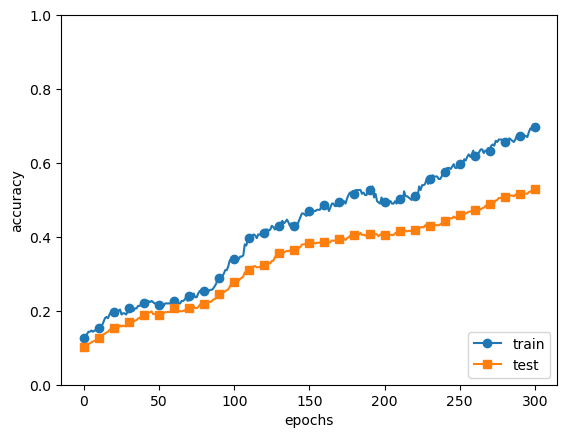

In [24]:
import os
import sys
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:300]
t_train = t_train[:300]

use_dropout = True
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

通过使用Dropout，训练数据和测试数据的识别精度的差距变小了。并且，训练数据也没有到达100%的识别精度。像这样，通过使用Dropout，即便是表现力强的网络，也可以抑制过拟合。

# 超参数的验证

## 验证数据
神经网络中，除了权重和偏置等参数，超参数（hyper-parameter）也经常出现。这里所说的超参数是指，比如各层的神经元数量、batch大小、参数更新时的学习率或权值衰减等。如果这些超参数没有设置合适的值，模型的性能就会很差。虽然超参数的取值非常重要，但是在决定超参数的过程中 一般会伴随很多的试错。

这里要注意的是，不能使用测试数据评估超参数的性能。这一点非常重要，但也容易被忽视。这是因为如果使用测试数据调整超参数，超参数的值会对测试数据发生过拟合。换句话说，用测试数据确认超参数的值的“好坏”，就会导致超参数的值被调整为只拟合测试数据。 这样的话，可能就会得到不能拟合其他数据、泛化能力低的模型。

因此，调整超参数时，必须使用超参数专用的确认数据。用于调整超参数的数据，一般称为验证数据（validation data）。我们使用这个验证数据来评估超参数的好坏。

根据不同的数据集，有的会事先分成训练数据、验证数据、测试数据三部分，有的只分成训练数据和测试数据两部分，有的则不进行分割。在这种情况下，用户需要自行进行分割。最简单的做法就是从训练数据中事先分割20%作为验证数据，代码如下：

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 打乱训练数据, 避免数据可能存在的偏向
x_train, t_train = shuffle_dataset(x_train, t_train)

# 将 20% 作为验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

## 超参数最优化
进行超参数的最优化时，逐渐缩小超参数的“好值”的存在范围非常重要。所谓逐渐缩小范围，是指一开始先大致设定一个范围，从这个范围中随机选出一个超参数（采样），用这个采样到的值进行识别精度的评估；然后，多次重复该操作，观察识别精度的结果，根据这个结果缩小超参数的“好值”的范围。通过重复这一操作，就可以逐渐确定超参数的合适范围。

超参数的范围只要“大致地指定”就可以了。所谓“大致地指定”，是指以“10的阶乘”的尺度指定范围。在超参数的搜索中，需要尽早放弃那些不符合逻辑的超参数。于是，在超参数的最优化中，减少学习的epoch，缩短一次评估所需的时间是一个不错的办法。

以上就是超参数的最优化的内容，简单归纳一下，如下所示。
- 步骤0 设定超参数的范围。 
- 步骤1 从设定的超参数范围中随机采样。 
- 步骤2 使用步骤1中采样到的超参数的值进行学习，通过验证数据评估识别精度（但是要将epoch设置得很小）。 
- 步骤3 重复步骤1和步骤2（100次等），根据它们的识别精度的结果，缩小超参数的范围。

反复进行上述操作，不断缩小超参数的范围，在缩小到一定程度时，从该范围中选出一个超参数的值。这就是进行超参数的最优化的一种方法。

> 在超参数的最优化中，如果需要更精炼的方法，可以使用贝叶斯最优化（Bayesian optimization）。

## 超参数优化实现

现在，我们使用MNIST数据集进行超参数的最优化。这里我们将学习率和控制权值衰减强度的系数（下文称为“权值衰减系数”）这两个超参数的搜索问题作为对象。

在该实验中，权值衰减系数的初始范围为$10^{−8}$到$10^{−4}$,学习率的初始范围为$10^{−6}$到$10^{−2}$。此时，超参数的随机采样的代码如下所示。

In [ ]:
weight_decay = 10 ** np.random.uniform(-8, -4)
lr = 10 ** np.random.uniform(-6, -2)

像这样进行随机采样后，再使用那些值进行学习。之后，多次使用各种超参数的值重复进行学习，观察合乎逻辑的超参数在哪里。

![Hyper Parameter](img/hyperparam.webp)

上图中，按识别精度从高到低的顺序排列了验证数据的学习的变化。 从图中可知，直到“Best-5”左右，学习进行得都很顺利。从这个结果可以看出，学习率在0.001到0.01、权值衰减系数在10−8 到 10−6 之间时，学习可以顺利进行。像这样，观察可以使学习顺利进行的超参数的范围，从而缩小值的范围。然后，在这个缩小的范围中重复相同的操作。这样就能缩小到合适的超参数的存在范围，然后在某个阶段，选择一个最终的超参数的值。